# Approximate value function
*This notebook is full of undocumented and broken code.*

In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
import itertools as it
from collections import Counter, defaultdict, deque
from toolz.curried import memoize, get
from random import choice
from tqdm import tqdm_notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imported from MetaTree

In [25]:
# Plotting decision trees
from IPython.display import display
from meta_tree import MetaTree
from IPython.display import Image
COLOR = {None: 'grey', np.inf: 'grey', 1: '#dd4444', 0: '#5555ee'}
from graphviz import Digraph
def draw_tree(state):
    dot = Digraph()
    for x, ys in enumerate(mt.tree):
        c = COLOR[state[x]]
        dot.node(str(x), style='filled', color=c)
        for y in ys:
            dot.edge(str(x), str(y))
    display(dot)

In [5]:
from toolz import identity
identity(1, 2)

TypeError: identity() takes 1 positional argument but 2 were given

In [26]:
def sort_tree(mt, state):
    """Breaks symmetry between belief states.
    
    This is done by enforcing that the knowldge about states at each
    depth be sorted by [0, 1, UNKNOWN]
    """
    state = list(state)
    for i in range(len(mt.tree) - 1, -1, -1):
        if not mt.tree[i]:
            continue  # 
        c1, c2 = mt.tree[i]
        if not (mt.subtree(state, c1) <= mt.subtree(state, c2)):
            diff = c2 - c1
            for j in range(c1, c2):
                state[j], state[j+diff] = state[j+diff], state[j]
    return tuple(state)

def solve(mdp, hash_state=None, actions=None):
    """Returns Q, V, pi, and computation data for an mdp."""
    if actions is None:
        actions = mdp.actions
    if hash_state is None:
        hash_state = lambda s: sort_tree(mt, s)
    info = {  # track number of times each function is called
        'q': 0,
        'v': 0
    }

    @memoize
    def Q(s, a):
        info['q'] += 1
        return sum(p * (r + V(s1)) for p, s1, r in mdp.results(s, a))

    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return hash_state(args[0])

    if hash_state is None:
        hash_key = None
        
    @memoize(key=hash_key)
    def V(s):
        if s is None:
            return 0
        info['v'] += 1
        return max(Q(s, a) for a in actions(s))
    
    @memoize
    def pi(s):
        return max(actions(s), key=lambda a: Q(s, a))
    
    return Q, V, pi, info

mt = MetaTree(2, 2, cost=-.1)
Q, V, pi, info = solve(mt)  # note: no computation actually happens here.
print('Value:', V(mt.init))  # calling V(mt.init) runs the algorithm
print('Computations:', info)

Value: 1.80625
Computations: {'q': 513, 'v': 171}


# Distributions
Code for handling probability distributions of possible
 outcomes of observations.

In [41]:


def cross(d1, d2, f):
    outcomes = Counter()
    for ((p1, o1), (p2, o2)) in it.product(d1, d2):
        outcomes[f(o1, o2)] += p1 * p2
    return [(p, v) for v, p in outcomes.items()]


def expectation(dist):
    return sum(p * v for p, v in dist)

OBS = 'OBS'  # indicates a node that will be observed
def outcomes(mt, state, n):
    d = []
    if state[n] == OBS:
        for r in mt.outcomes:
            d.append((mt.outcome_prob, r))
    elif state[n] is mt.unknown:
        d.append((1, mt.expected_outcome))
    else:
        d.append((1, state[n]))
    return d

def info_V_dist(mt, state, n):
    def rec(p, s):
        if mt.tree[s]:
            # assume 2 branch
            child_vs = [list(rec(p * 0.5, s1)) for s1 in mt.tree[s]]
            v_dist = cross(*child_vs, f=max)
            r_dist = outcomes(mt, state, s)
#             print(s, r_dist, v_dist, child_vs)
            yield from cross(r_dist, v_dist, f=lambda x, y: x+y)
        else:
            yield from outcomes(mt, state, s)
    return list(rec(1, n))

# Features

In [56]:
def VOC1(mt, state, action):
    val_term_next = sum(p * (r + mt.term_value(s1))
        for p, s1, r in mt.results(state, action))
    return val_term_next - mt.term_value(state)

def VOC1_alt(mt, state, action):
    return VOI(mt, state, [action])

# VOC1_alt(mt, state, 6)
    
# state = update(mt.init, OBS, 1)
VOC1(mt, mt.init, 1), VOC1_alt(mt, mt.init, 1)

(0.1499999999999999, 0.25)

In [20]:
def update(state, val, *nodes):
    state = list(state)
    for n in nodes:
        state[n] = val
    return tuple(state)

def replace(state, v1, v2, nodes=None):
    if nodes is None:
        nodes = range(len(state))
    state = list(state)
    for n in nodes:
        if state[n] == v1:
            state[n] = v2
    return tuple(state)    

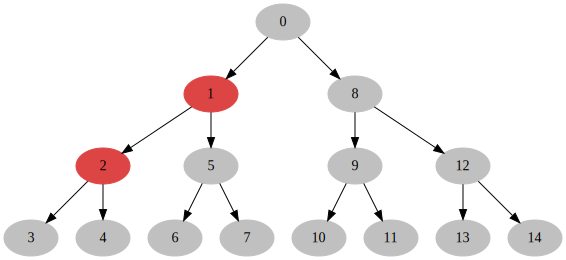

0.15234375 0.391357421875


In [43]:
def VPI_action(mt, state, action):
    choices = list(mt.tree[0])
    relevant_choice = choices[0] if action < choices[1] else choices[1]
    stop = relevant_choice + choices[1] - choices[0]
    return VOI(mt, state, range(relevant_choice, stop))

def VPI_full(mt, state):
    return VOI(mt, state, range(len(state)))

def VOI(mt, state, nodes_to_observe, n=0):
    new_state = replace(state, mt.unknown, OBS, nodes_to_observe)
    info_val = expectation(info_V_dist(mt, new_state, n))
    return info_val - mt.tree_V(state, n)

mt = MetaTree(2, 3, cost=-0.1)
state = list(mt.init)
state[1] = 1
state[2] = 1
# state[3] = 0
# state[4] = 0
# state[5] = 0
# state[8] = 0
state = tuple(state)
draw_tree(state)
print(VPI_action(mt, state, 8), VPI_full(mt, state))
# print(VOC1(mt, state, s), VOC1_alt(mt, state, s))

In [330]:
def pruned_actions(mt, state):
    """Returns a subset of actions available at state.
    
    The subset is guaranteed to include an optimal action."""
    def search(i):
        if state[i] is mt.unknown and i > 0:
            yield i  # a possible computation
        if mt.tree[i]:
            c1, c2 = mt.tree[i]
            yield from searchr(c1)
            if mt.subtree(state, c1) != mt.subtree(state, c2):
                yield from search(c2)  # no pruning this time
    yield from search(0)
    yield mt.term_action

In [339]:
def phi(s, a):
    if a is mt.term_action:
        return ([0, 0, 0, mt.term_value(s), 0])
    else:
        return ([VOC1(mt, s, a), VPI(mt, s), VPI_action(mt, s, a), mt.term_value(s), mt.cost])

In [413]:
%%time
# Compute exact solution.
mt= MetaTree(2, 3, outcomes=(0,1,2), cost=-0.1)
Q, V, pi, info = solve(mt)
V(mt.init)

CPU times: user 24min 19s, sys: 1min 36s, total: 25min 55s
Wall time: 26min 27s


In [360]:
from meta_tree import Labeler
mt = MetaTree(2, 3, outcomes=(0,1), cost=-0.1)
Q, V, pi, info = solve(mt)
states = it.product((mt.unknown, *mt.outcomes), repeat=len(mt.tree))
non_sym = list(set(tqdm((sort_tree(mt, s) for s in states),
                   total=(len(mt.outcomes) + 1) ** len(mt.tree))))
Qmat = np.full((len(non_sym), len(mt.tree)+1), np.nan)

state_labeler = Labeler()

states = []
actions = []
Q_star = []
features = []
pi_hat = []
pi_mat = []
for i, s in enumerate(tqdm(non_sym)):
    acts = []
    if s is None:
        continue
    for a in pruned_actions(mt, s):
        state_labeler(s)
        states.append(s)
        actions.append(a)
        Q_star.append(Q(s, a))
        acts.append((Q(s, a), a))
        features.append(phi(s, a))
    pi_hat.append(max(acts)[1])
    pi_mat.append(pi(s))

In [374]:
def rms(y_hat, y):
    return ((y_hat - y) ** 2).mean() ** 0.5
y = np.array(Q_star)
X = np.array(features)
pi_hat = np.array(pi_hat)
pi_mat = np.array(pi_mat)

beta = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X @ beta

print(beta)
print(rms(y_hat, y))
print(rms(y.mean(), y))
print((pi_hat == pi_mat).mean())

[ 0.42975515  0.47647896  0.04689218  1.00015308  0.60993898]
0.0244135704101
0.597174291105
0.704189136915


In [392]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [400]:
voc, vpi, vpi_a, term, cost = X.T
err = y - y_hat
df = pd.DataFrame({'voc': voc, 'vpi_full': vpi, 'vpi_a': vpi_a, 'term': term, 'cost': mt.cost,
                   'err': err, 'y': y, 'y_hat': y_hat, 'state': states, 'action': actions})
df = df.round(4)

In [401]:
rdf = df.drop('state', 1)

In [404]:
%%R -i rdf
m = lm('y ~ voc + vpi_full + vpi_a + term + cost', data=rdf)
print(m)
m0 = update(m, . ~ . - vpi_a)
anova(m0, m)


Call:
lm(formula = "y ~ voc + vpi_full + vpi_a + term + cost", data = rdf)

Coefficients:
(Intercept)          voc     vpi_full        vpi_a         term         cost  
   -0.02027      0.58722      0.42874     -0.02151      0.99712           NA  

Analysis of Variance Table

Model 1: y ~ voc + vpi_full + term + cost
Model 2: y ~ voc + vpi_full + vpi_a + term + cost
   Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1 1905278 1819.9                                  
2 1905277 1815.8  1    4.0779 4278.8 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


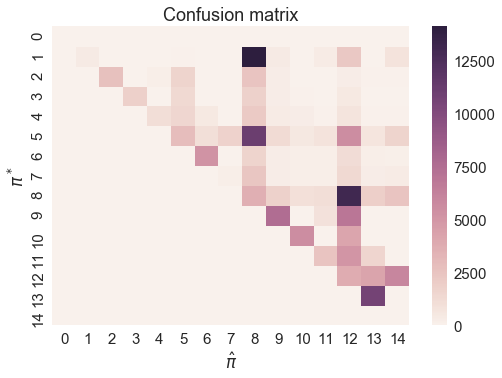

In [376]:

from sklearn.metrics import confusion_matrix
C = confusion_matrix(pi_mat, pi_hat, labels=range(mt.term_action+1))
with sns.plotting_context(font_scale=1.5):
    sns.heatmap(C[:-1, :-1])
    # sns.heatmap(C)
    plt.ylabel(r'$\pi^*$')
    plt.xlabel(r'$\hat\pi$')
    plt.title('Confusion matrix')

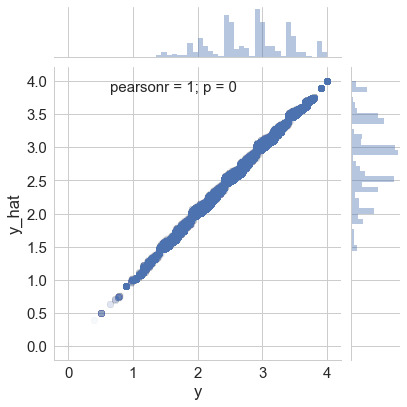

In [366]:
# df['pi_star'] = df.state.apply(pi)
sns.jointplot('y', 'y_hat', data=df, alpha=.01)
# sns.jointplot('y', 'y_hat', data=df.query('pi_hat == 7'), kind='kde')

(0, 4)

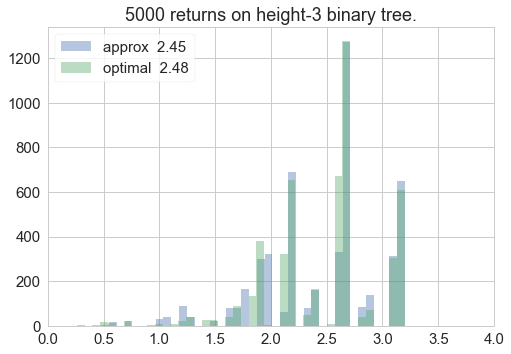

In [391]:
def run_episode(mt, pi, s=None):
    """Runs a single random episode with policy pi."""
    if s is None:
        s = mt.init
    acts = []
    reward = 0
    s1 = s
    while True:
        s0 = s1
        a = pi(s0)
        p, s1, r = choice(mt.results(s0, a))
        acts.append(a)
        reward += r
        if a == mt.term_action:
#             draw_tree(states[-1])
            return acts, reward

def run_many(mt, pi, N=1000):
    for _ in range(N):
        actions, reward = run_episode(mt, pi)
        yield reward 

from toolz import curry
@curry
def mat_pi(pi_mat, s):
    i = state_labeler(sort_tree(mt, s))
    return pi_mat[i]
    # dd = df.query('state == @s')
    # return dd.action[dd.y_hat.argmax()]

@curry
def Q_hat(s, a):
    x = phi(s, a)
    return x @ beta

def pi_hat2(s):
    return max((a for a in mt.actions(s)), key=Q_hat(s))

# hat_returns = pd.Series(run_many(mt, pi_hat2, N=5000))
# opt_returns = pd.Series(run_many(mt, pi, N=5000))
sns.distplot(hat_returns, label='approx  {:.2f}'.format(hat_returns.mean()),kde=0)
sns.distplot(opt_returns, label='optimal  {:.2f}'.format(opt_returns.mean()),kde=0)
plt.legend(frameon=True)
plt.title('5000 returns on height-3 binary tree.')
plt.xlim(0, 4)
# draw_tree(S)
# Q_hat(mt.init, 8)
# print(phi(mt.init, 8))
# print(phi(mt.init, 1))

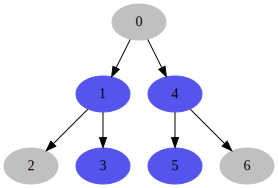

In [107]:
draw_tree((inf, 0, inf, 0, 0, 0, inf))


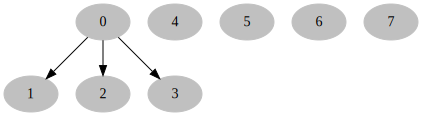

In [129]:
mt = MetaTree(3, 1)
draw_tree(mt.init)